In [1]:
from astropy.io import ascii
from matplotlib import pyplot as plt
import numpy as np
import astropy.constants as const
from scipy import integrate

In [2]:
c=3e10
hh = 6.62607551e-27
kb = 1.38006504e-16

In [3]:
ssc=ascii.read('SSCmodel.csv', format='basic', delimiter=',', guess=False) 

In [4]:
# lower coronal model
height = ssc['H'].data
ne_md = ssc['NEL'].data
ni_md = ssc['NI'].data
ta_md = ssc['TA'].data

In [5]:
# saito 
def dens_corona(r): 
    # in solar radii
    return 1.25*(1.36e6 * r**(-2.14) + 1.68e8 * r**(-6.13))

In [6]:
height_extend= np.logspace(np.log10(np.max(height)),np.log10((const.R_sun.value/1e3)*3),20)
rr_arr = 1 + height_extend / (const.R_sun.value/1e3)
ne_extend = dens_corona(rr_arr)
ta_extend = np.ones(height_extend.shape)*ta_md[-1]

[None, None, Text(0.5, 0, 'Height (km)'), Text(0, 0.5, 'T (K)')]

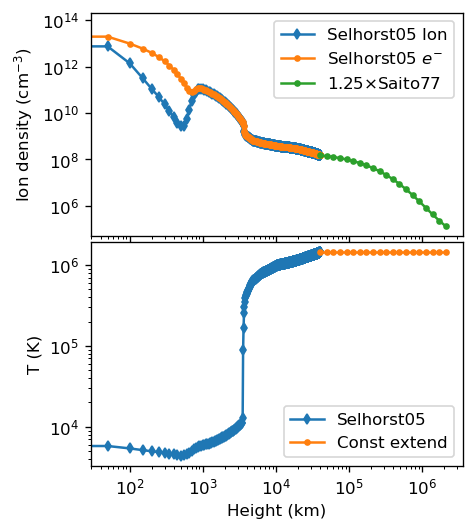

In [7]:
fig,(ax0, ax1) =plt.subplots(2,1,figsize=[4,5],dpi=120,sharex=True)
plt.subplots_adjust( hspace=0.025)

l1,=ax0.plot(height, ni_md,'d-',markersize=4)
ax0.set(xscale='log',yscale='log',
       ylabel=r'Ion density ($\rm cm^{-3}$)')
l2,=ax0.plot(height,ne_md,'.-')
l3,=ax0.plot(height_extend,ne_extend,'.-')
ax0.legend([l1,l2,l3],['Selhorst05 Ion','Selhorst05 $e^{-}$',r'1.25$\times$Saito77'])

l11,=ax1.plot(height, ta_md,'d-',markersize=4)
l12,=ax1.plot(height_extend, ta_extend,'.-')
ax1.legend([l11,l12],['Selhorst05','Const extend'])
ax1.set(xscale='log',yscale='log',xlabel='Height (km)',ylabel=r'T (K)')

In [54]:
# reverse for integral
height_all = np.flipud(np.concatenate([height,height_extend]))
ne_all = np.flipud(np.concatenate([ne_md,ne_extend]))
ni_all = np.flipud(np.concatenate([ni_md,ne_extend]))
ta_all = np.flipud(np.concatenate([ta_md,ta_extend]))

[Text(0.5, 0, 'Height'), Text(0, 0.5, 'T (K)')]

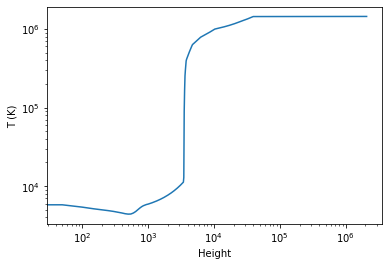

In [55]:
plt.loglog(height_all,ta_all)
plt.gca().set(xlabel='Height',ylabel='T (K)')

In [56]:
f0 = 2e9
lambda0=c/f0

In [57]:
z=1.178
g=(1.27*(2.78+np.log10(ta_all)-np.log10((ni_all))/3)) # Gaunt factor Zirin 1988 - Used in SSC 2005
kff=((2e-23)*z**2 * g * (lambda0)**(2)*ni_all*ne_all*ta_all**(-3/2.)*1e5) # Used in SSC 2005

In [58]:
# optical depth
# integral from corona to sun
tau = np.array([integrate.trapz(kff[0:idx],-height_all[0:idx])
       for idx in np.arange(height_all.shape[0]-1)+1])
Tb=integrate.trapz(ta_all[1:]*kff[1:]*np.exp(-tau),-height_all[1:])

[Text(0.5, 0, 'Height'), Text(0, 0.5, '$\\tau$')]

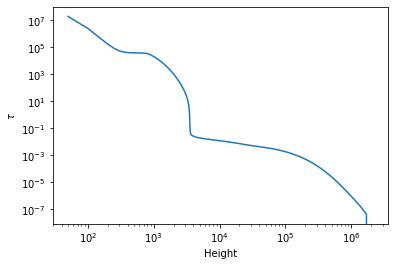

In [59]:
plt.loglog(height_all[0:-1],np.abs(tau))
plt.gca().set(xlabel='Height',ylabel=r'$\tau$')

In [64]:
# calc spectrum

Tb_arr =np.zeros(50)
freq_arr = np.logspace(7,10.5,50)
for idx,freq in enumerate(freq_arr):
    lambda0=c/freq
    z=1.178
    g=(1.27*(2.78+np.log10(ta_all)-np.log10((ni_all))/3)) # Gaunt factor Zirin 1988 - Used in SSC 2005
    kff=((2e-23)*z**2 * g * (lambda0)**(2)*ni_all*ne_all*ta_all**(-3/2.)*1e5) # Used in SSC 2005
    tau = np.array([integrate.trapz(kff[1:idx+1],-height_all[1:idx+1]) # remove edge point [essentail]
       for idx in np.arange(height_all.shape[0]-1)+1])
    Tb_arr[idx]=integrate.trapz(ta_all[1:]*kff[1:]*np.exp(-tau),-height_all[1:])
    

[Text(0.5, 0, 'Freq (MHz)'), Text(0, 0.5, '$T_b#$')]

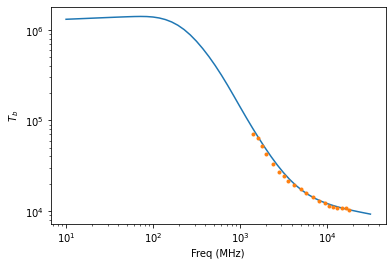

In [65]:
Z_obs=ascii.read('Z_obs.csv', format='basic', delimiter=',', guess=False) 
freq_obs,Tb_obs = (Z_obs['F']),(Z_obs['TBZ'])

plt.loglog(freq_arr/1e6,Tb_arr)
plt.plot(freq_obs*1e3,Tb_obs,'.')
plt.gca().set(xlabel='Freq (MHz)',ylabel=r'$T_b#$')